In [1]:
import os
import tensorflow as tf
import json
import pandas as pd
import numpy as np
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [57]:
# Folders, named after the file label
labels = ["LEFT_ONE", "LEFT_TWO", "LEFT_THREE",
          "RIGHT_ONE", "RIGHT_TWO", "RIGHT_THREE"]

# Store the dataframes
dataframes = []

# Go through each label
for label in labels:
    # Go through each file in folder
    folder_path = os.listdir(label)

    for file_name in folder_path:
        # Read the file
        df = pd.read_parquet(f"{label}/{file_name}")
        df["sign"] = labels.index(label)
        dataframes.append(df)

    print(f"{label} has been processed!")




LEFT_ONE has been processed!
LEFT_TWO has been processed!
LEFT_THREE has been processed!
RIGHT_ONE has been processed!
RIGHT_TWO has been processed!
RIGHT_THREE has been processed!


In [58]:
dataframes[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, LeftX to RightY
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4 non-null      float64
 1   1       4 non-null      float64
 2   2       4 non-null      float64
 3   3       4 non-null      float64
 4   4       4 non-null      float64
 5   5       4 non-null      float64
 6   6       4 non-null      float64
 7   7       4 non-null      float64
 8   8       4 non-null      float64
 9   9       4 non-null      float64
 10  10      4 non-null      float64
 11  11      4 non-null      float64
 12  12      4 non-null      float64
 13  13      4 non-null      float64
 14  14      4 non-null      float64
 15  15      4 non-null      float64
 16  16      4 non-null      float64
 17  17      4 non-null      float64
 18  18      4 non-null      float64
 19  19      4 non-null      float64
 20  20      4 non-null      float64
 21  sign    4 non-null      int64  
dtypes:

In [59]:
dataframes[0]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,sign
LeftX,0.328125,0.379688,0.421875,0.451562,0.446875,0.360938,0.35625,0.359375,0.362500,0.307812,...,0.415625,0.270313,0.342187,0.368750,0.373437,0.242188,0.303125,0.326562,0.326562,0
RightX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
LeftY,0.968750,0.937500,0.885417,0.845833,0.814583,0.727083,0.61875,0.543750,0.483333,0.733333,...,0.900000,0.768750,0.812500,0.891667,0.937500,0.818750,0.850000,0.904167,0.933333,0
RightY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [60]:
# Define empty lists to store features and labels
features_list = []
labels_list = []

for dataframe in dataframes:
    # Extract features (all columns except the last one) and labels (last column)
    features = dataframe.iloc[:, :-1].values
    labels = dataframe.iloc[:, -1].values

    features_list.append(features)
    labels_list.append(labels)

In [61]:
dataframes[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, LeftX to RightY
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4 non-null      float64
 1   1       4 non-null      float64
 2   2       4 non-null      float64
 3   3       4 non-null      float64
 4   4       4 non-null      float64
 5   5       4 non-null      float64
 6   6       4 non-null      float64
 7   7       4 non-null      float64
 8   8       4 non-null      float64
 9   9       4 non-null      float64
 10  10      4 non-null      float64
 11  11      4 non-null      float64
 12  12      4 non-null      float64
 13  13      4 non-null      float64
 14  14      4 non-null      float64
 15  15      4 non-null      float64
 16  16      4 non-null      float64
 17  17      4 non-null      float64
 18  18      4 non-null      float64
 19  19      4 non-null      float64
 20  20      4 non-null      float64
 21  sign    4 non-null      int64  
dtypes:

In [62]:
# Step 1: Convert Dataframes to Tensors
data_tensors = []

for df in dataframes:
    # Extract features and labels from the dataframe
    features = df.iloc[:, :-1].values  # Exclude the last column as it's the label
    labels = df['sign'].values
    
    # Convert to NumPy arrays
    features_array = np.array(features)
    labels_array = np.array(labels)
    
    # Convert to TensorFlow tensors
    features_tensor = tf.convert_to_tensor(features_array, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels_array, dtype=tf.int64)
    
    data_tensors.append((features_tensor, labels_tensor))

In [63]:
all_features = tf.concat([features_tensor for features_tensor, _ in data_tensors], axis=0)
all_labels = tf.concat([labels_tensor for _, labels_tensor in data_tensors], axis=0)

In [64]:
from sklearn.model_selection import train_test_split

features_tensor = features_tensor[:, np.newaxis, :]

# Assuming you have your data as TensorFlow tensors
features_train, features_val, labels_train, labels_val = train_test_split(
    features_tensor.numpy(), labels_tensor.numpy(), test_size=0.2, random_state=42)

In [72]:
# Step 4: Create an LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(1028, input_shape=(1, 21), return_sequences=True))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

# Step 5: Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the Model
trained_model = model.fit(features_train, labels_train, epochs=200, validation_data=(features_val, labels_val))

model.save("hand_model.h5")

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.7923 - accuracy: 0.0000e+00 - val_loss: 1.6203 - val_accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 73ms/step - loss: 1.7434 - accuracy: 1.0000 - val_loss: 1.4557 - val_accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 76ms/step - loss: 1.6952 - accuracy: 1.0000 - val_loss: 1.2947 - val_accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 79ms/step - loss: 1.6472 - accuracy: 1.0000 - val_loss: 1.1366 - val_accuracy: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 76ms/step - loss: 1.5991 - accuracy: 1.0000 - val_loss: 0.9820 - val_accuracy: 1.0000
Epoch 6/200
1/1 [==============================] - 0s 74ms/step - loss: 1.5505 - accuracy: 1.0000 - val_loss: 0.8322 - val_accuracy: 1.0000
Epoch 7/200
1/1 [==============================] - 0s 76ms/step - loss: 1.5015 - accuracy: 1.0000 - val_loss: 0.6894 - val_accuracy: 1.0000
Epoch 8/200
1/1 [=

C:\Users\antho\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


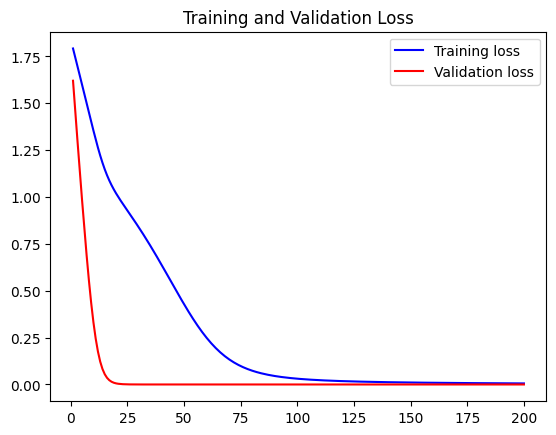

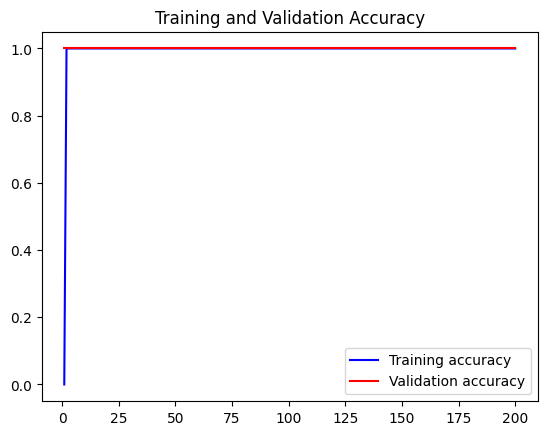

In [74]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()